In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from scipy.signal import savgol_filter
from imblearn.under_sampling import RandomUnderSampler 
from imblearn.over_sampling import SVMSMOTE, ADASYN, SMOTE, RandomOverSampler
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import balanced_accuracy_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier 

from sklearn.base import BaseEstimator
from sklearn.utils import resample
import time
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_validate
from xgboost import XGBClassifier
from scipy.stats import kurtosis
from scipy.stats import skew
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score

In [ ]:
df = pd.read_csv('pad_2021_dados_rotulados.csv')

In [ ]:
y = df.label
X_raw = df.drop(columns=['index','Unnamed: 0',	'Unnamed: 0.1','NÃºmero de sÃ©rie do instrumento',
       'Temperatura', 'Notas', 'Carimpo de Tempo', 'numero_sus', 'patologia',
       'label'])
X_raw2 = df.groupby('numero_sus',as_index=False).mean().drop(columns=['index','Unnamed: 0',
       'Temperatura', 'Notas', 'numero_sus',
       'label'])
y2 = df.groupby('numero_sus',as_index=False).mean()['label'].values
y3 = df.groupby('numero_sus',as_index=False).mean()['label2'].values

In [ ]:
X = pd.DataFrame(savgol_filter(X_raw, window_length=9, polyorder=2),columns=X_raw.columns.astype(float))
X2 = pd.DataFrame(savgol_filter(X_raw2, window_length=9, polyorder=2),columns=X_raw.columns.astype(float))

In [ ]:
def snv(input_data):
    """
        :snv: A correction technique which is done on each
        individual spectrum, a reference spectrum is not
        required
        :param input_data: Array of spectral data
        :type input_data: DataFrame
        
        :returns: data_snv (ndarray): Scatter corrected spectra
    """
    
    input_data = np.asarray(input_data)
    
    # Define a new array and populate it with the corrected data  
    data_snv = np.zeros_like(input_data)
    for i in range(data_snv.shape[0]):
        # Apply correction
        data_snv[i,:] = (input_data[i,:] - np.mean(input_data[i,:])) / np.std(input_data[i,:])
    
    return data_snv

In [ ]:
def windowing(vec, w, overlap):
    overlap = 1 - overlap
    line = []
    for i in range(0,125,int((w*overlap))):
        v = vec[i:int(i+(w*overlap))]
        line += [np.mean(v),np.std(v),kurtosis(v),skew(v), np.amax(v), np.amin(v)]
  
    return line

In [ ]:
def get_dummy_matrix(labels):

    unique_labels = np.unique(labels)

    #if unique_labels.shape[0] > 0:
    dummy_matrix = np.zeros((unique_labels.shape[0], labels.shape[0]))

    for i in range(0, labels.shape[0]):
        for j in range(0, unique_labels.shape[0]):
            if (labels[i]) == j:
                dummy_matrix[j][i] = 1
            else:
                dummy_matrix[j][i] = 0
    return dummy_matrix

In [ ]:
X = pd.DataFrame(snv(X2),columns=X_raw.columns.astype(float))

Text(0.5, 1.0, 'Dados espectrais após SNV')

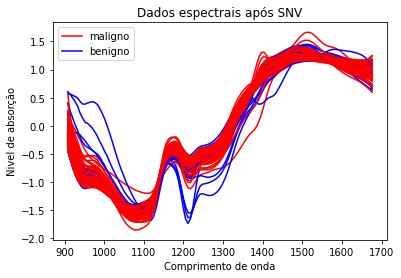

In [ ]:
fig = plt.figure()
for i, row in X.iterrows():
    if y[i] == 0:
        plt.plot(X.columns,row,color='blue', label = 'benigno')
    elif y[i] == 1:
        plt.plot(X.columns,row,color='red', label = 'maligno')

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.xlabel('Comprimento de onda')
plt.ylabel('Nivel de absorção')
plt.title('Dados espectrais após SNV')



In [ ]:
b = X[X.index.isin(np.where(y == 0)[0])].mean()
plt.plot(X.drop(columns='id').columns,b,color='blue', label = 'benigno')
m = X[X.index.isin(np.where(y == 1)[0])].mean()
plt.plot(X.drop(columns='id').columns,m,color='red', label = 'maligno')
plt.xlabel('Comprimento de onda')
plt.ylabel('Nivel de absorção')
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

KeyError: ignored

PCA

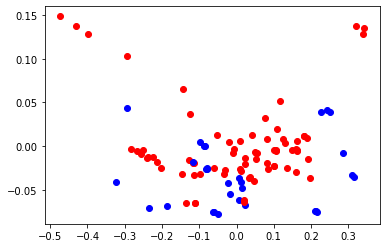

In [ ]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_raw)

for i in range(X2.shape[0]):
  if y[i] == 0:
    plt.scatter(X_pca[i,0],X_pca[i,1],color='blue')
  else:
    plt.scatter(X_pca[i,0],X_pca[i,1],color='red')

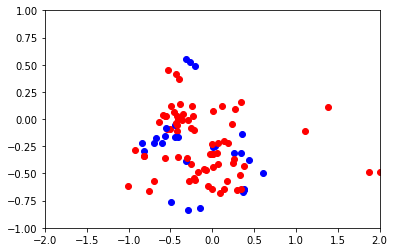

In [ ]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_25)
plt.xlim(-2,2)
plt.ylim(-1,1)
for i in range(X2.shape[0]):
  if y[i] == 0:
    plt.scatter(X_pca[i,0],X_pca[i,1],color='blue')
  else:
    plt.scatter(X_pca[i,0],X_pca[i,1],color='red')

TSNE

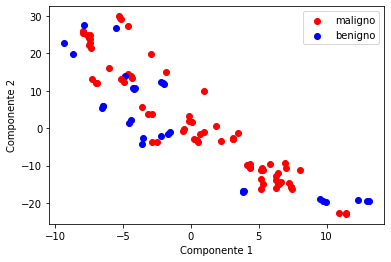

In [ ]:
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2,learning_rate='auto', init='random').fit_transform(X_raw)
for i in range(X2.shape[0]):
  if y[i] == 0:
    plt.scatter(X_embedded[i,0],X_embedded[i,1],color='blue', label = 'benigno')
  else:
    plt.scatter(X_embedded[i,0],X_embedded[i,1],color='red', label = 'maligno')
plt.xlabel('Componente 1')
plt.ylabel('Componente 2')
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  FutureWarning,


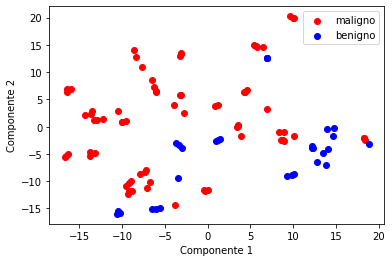

In [ ]:
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2,learning_rate='auto', init='random').fit_transform(X)
for i in range(X2.shape[0]):
  if y[i] == 0:
    plt.scatter(X_embedded[i,0],X_embedded[i,1],color='blue', label = 'benigno')
  else:
    plt.scatter(X_embedded[i,0],X_embedded[i,1],color='red', label = 'maligno')
plt.xlabel('Componente 1')
plt.ylabel('Componente 2')
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

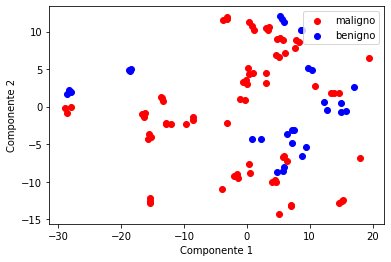

In [ ]:
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2,learning_rate='auto', init='random').fit_transform(X_25)
for i in range(X2.shape[0]):
  if y[i] == 0:
    plt.scatter(X_embedded[i,0],X_embedded[i,1],color='blue', label = 'benigno')
  else:
    plt.scatter(X_embedded[i,0],X_embedded[i,1],color='red', label = 'maligno')
plt.xlabel('Componente 1')
plt.ylabel('Componente 2')
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

In [ ]:
X_50 = np.apply_along_axis(windowing,1,X, w=50,overlap=0.5)
X_25 = np.apply_along_axis(windowing,1,X, w=25,overlap=0.5)

In [ ]:
X['id']= df.numero_sus

In [ ]:
numero_sus =  df.groupby('numero_sus',as_index=False).mean()['numero_sus']
y_numero_sus = df.groupby('numero_sus',as_index=False).mean()['label']

In [ ]:
cols = X.drop(columns='id').columns

In [ ]:
cols

Index([   908.1,  914.294,  920.489,  926.683,  932.877,  939.072,  945.266,
         951.46,  957.655,  963.849,
       ...
       1620.451, 1626.645, 1632.839, 1639.034, 1645.228, 1651.423, 1657.617,
       1663.811, 1670.006,   1676.2],
      dtype='object', length=125)

**preprocessado**

**svm**

In [ ]:
kf = StratifiedKFold(n_splits=5, shuffle=False)

bacc_per_fold = []
acc_per_fold = []
pre_per_fold = []
rec_per_fold = []
cm = []
hp = []

for train_index, test_index in kf.split(numero_sus, y_numero_sus):
    index_train_sus, index_test_sus = X.id.isin(numero_sus[train_index]), X.id.isin(numero_sus[test_index])
    X_train, y_train = X.loc[index_train_sus,cols], y[index_train_sus]
    X_test, y_test = X.loc[index_test_sus,cols], y[index_test_sus]

    rus = RandomUnderSampler(random_state=42)
    X_train, y_train = rus.fit_resample(X_train, y_train)
    
    grade={'C':[1,10,100,1000],
       'gamma':[1,0.1,0.001,0.0001], 
       'kernel':['linear','rbf']}

    model = SVC()
    gs = GridSearchCV(estimator=model, param_grid = grade,
                  scoring='balanced_accuracy', cv = 5)
    gs.fit(X_train, y_train)
    
    pred = gs.predict(X_test)
    
    hp.append(gs.best_params_)
    cm.append(confusion_matrix(y_test, pred))
    bacc_per_fold.append(balanced_accuracy_score(y_test, pred))
    acc_per_fold.append(accuracy_score(y_test, pred))
    pre_per_fold.append(precision_score(y_test, pred))
    rec_per_fold.append(recall_score(y_test, pred))

print("bacc: {} +- {}, acc: {} +- {}, pr: {} +- {}, rec: {} +- {}".format(np.mean(bacc_per_fold), np.std(bacc_per_fold),np.mean(acc_per_fold), np.std(acc_per_fold),
                                                              np.mean(pre_per_fold), np.std(pre_per_fold),
                                                              np.mean(rec_per_fold), np.std(rec_per_fold)))

bacc: 0.512361111111111 +- 0.14974927605505262, acc: 0.5723809523809523 +- 0.11561658949820208, pr: 0.7516696920798644 +- 0.09909147482983942, rec: 0.6247222222222222 +- 0.15029395065982618


In [ ]:
print('list cm: {} \n cm: {}'.format(cm, sum(cm)))
print('hiperparametros: {}'.format(hp))
print("bacc: {}, acc: {}, pr: {}, rec: {}".format(bacc_per_fold,acc_per_fold,pre_per_fold,rec_per_fold))

list cm: [array([[ 9,  9],
       [21, 24]]), array([[ 9,  9],
       [28, 17]]), array([[ 0, 15],
       [10, 38]]), array([[ 2, 13],
       [15, 33]]), array([[13,  2],
       [12, 33]])] 
 cm: [[ 33  48]
 [ 86 145]]
hiperparametros: [{'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}, {'C': 1000, 'gamma': 1, 'kernel': 'rbf'}, {'C': 1000, 'gamma': 1, 'kernel': 'rbf'}, {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}, {'C': 100, 'gamma': 1, 'kernel': 'rbf'}]
bacc: [0.5166666666666666, 0.4388888888888889, 0.3958333333333333, 0.41041666666666665, 0.8], acc: [0.5238095238095238, 0.4126984126984127, 0.6031746031746031, 0.5555555555555556, 0.7666666666666667], pr: [0.7272727272727273, 0.6538461538461539, 0.7169811320754716, 0.717391304347826, 0.9428571428571428], rec: [0.5333333333333333, 0.37777777777777777, 0.7916666666666666, 0.6875, 0.7333333333333333]


**knn**

In [ ]:
kf = StratifiedKFold(n_splits=5, shuffle=False)

bacc_per_fold = []
acc_per_fold = []
pre_per_fold = []
rec_per_fold = []
cm = []
hp = []

for train_index, test_index in kf.split(numero_sus, y_numero_sus):
    index_train_sus, index_test_sus = X.id.isin(numero_sus[train_index]), X.id.isin(numero_sus[test_index])
    X_train, y_train = X.loc[index_train_sus,cols], y[index_train_sus]
    X_test, y_test = X.loc[index_test_sus,cols], y[index_test_sus]

    rus = RandomUnderSampler(random_state=42)
    X_train, y_train = rus.fit_resample(X_train, y_train)
    
    grade={'n_neighbors': list(range(31))}

    model = KNeighborsClassifier()
    gs = GridSearchCV(estimator=model, param_grid = grade,
                  scoring='balanced_accuracy', cv = 5)
    gs.fit(X_train, y_train)
    
    pred = gs.predict(X_test)
    
    hp.append(gs.best_params_)
    cm.append(confusion_matrix(y_test, pred))
    bacc_per_fold.append(balanced_accuracy_score(y_test, pred))
    acc_per_fold.append(accuracy_score(y_test, pred))
    pre_per_fold.append(precision_score(y_test, pred))
    rec_per_fold.append(recall_score(y_test, pred))

print("bacc: {} +- {}, acc: {} +- {}, pr: {} +- {}, rec: {} +- {}".format(np.mean(bacc_per_fold), np.std(bacc_per_fold),np.mean(acc_per_fold), np.std(acc_per_fold),
                                                              np.mean(pre_per_fold), np.std(pre_per_fold),
                                                              np.mean(rec_per_fold), np.std(rec_per_fold)))

bacc: 0.47430555555555554 +- 0.17903742108327003, acc: 0.5366666666666667 +- 0.09138281482892144, pr: 0.7449601016587872 +- 0.131965991455099, rec: 0.6019444444444444 +- 0.051306991798461606


In [ ]:
print('list cm: {} \n cm: {}'.format(cm, sum(cm)))
print('hiperparametros: {}'.format(hp))
print("bacc: {}, acc: {}, pr: {}, rec: {}".format(bacc_per_fold,acc_per_fold,pre_per_fold,rec_per_fold))

list cm: [array([[ 8, 10],
       [18, 27]]), array([[ 4, 14],
       [16, 29]]), array([[ 0, 15],
       [23, 25]]), array([[ 1, 14],
       [16, 32]]), array([[15,  0],
       [19, 26]])] 
 cm: [[ 28  53]
 [ 92 139]]
hiperparametros: [{'n_neighbors': 7}, {'n_neighbors': 1}, {'n_neighbors': 1}, {'n_neighbors': 1}, {'n_neighbors': 2}]
bacc: [0.5222222222222221, 0.43333333333333335, 0.2604166666666667, 0.36666666666666664, 0.7888888888888889], acc: [0.5555555555555556, 0.5238095238095238, 0.3968253968253968, 0.5238095238095238, 0.6833333333333333], pr: [0.7297297297297297, 0.6744186046511628, 0.625, 0.6956521739130435, 1.0], rec: [0.6, 0.6444444444444445, 0.5208333333333334, 0.6666666666666666, 0.5777777777777777]


**xgboost**

In [ ]:
kf = StratifiedKFold(n_splits=5, shuffle=False)

bacc_per_fold = []
acc_per_fold = []
pre_per_fold = []
rec_per_fold = []
cm = []
hp = []

for train_index, test_index in kf.split(numero_sus, y_numero_sus):
    index_train_sus, index_test_sus = X.id.isin(numero_sus[train_index]), X.id.isin(numero_sus[test_index])
    X_train, y_train = X.loc[index_train_sus,cols], y[index_train_sus]
    X_test, y_test = X.loc[index_test_sus,cols], y[index_test_sus]

    rus = RandomUnderSampler(random_state=42)
    X_train, y_train = rus.fit_resample(X_train, y_train)
    
    grade={
        'colsample_bytree': [0.6, 0.8, 1.0],
        'n_estimators': [10, 25, 50],
       'max_depth': [5, 10, 20],
       'max_features': ['auto', 'sqrt'],
       'min_samples_leaf': [1, 2, 4],
       'min_samples_split': [2, 5, 10]
        }

    model = XGBClassifier()
    gs = GridSearchCV(estimator=model, param_grid = grade,
                  scoring='balanced_accuracy', cv = 5)
    gs.fit(X_train, y_train)
    
    pred = gs.predict(X_test)
    
    hp.append(gs.best_params_)
    cm.append(confusion_matrix(y_test, pred))
    bacc_per_fold.append(balanced_accuracy_score(y_test, pred))
    acc_per_fold.append(accuracy_score(y_test, pred))
    pre_per_fold.append(precision_score(y_test, pred))
    rec_per_fold.append(recall_score(y_test, pred))
    print('for')

print("bacc: {} +- {}, acc: {} +- {}, pr: {} +- {}, rec: {} +- {}".format(np.mean(bacc_per_fold), np.std(bacc_per_fold),np.mean(acc_per_fold), np.std(acc_per_fold),
                                                              np.mean(pre_per_fold), np.std(pre_per_fold),
                                                              np.mean(rec_per_fold), np.std(rec_per_fold)))

for
for
for
for
for
bacc: 0.49944444444444436 +- 0.10104622460128256, acc: 0.5676190476190477 +- 0.049156144383100724, pr: 0.7465079365079366 +- 0.04538017232572419, rec: 0.6366666666666666 +- 0.026140645235596865


In [ ]:
print('list cm: {} \n cm: {}'.format(cm, sum(cm)))
print('hiperparametros: {}'.format(hp))
print("bacc: {}, acc: {}, pr: {}, rec: {}".format(bacc_per_fold,acc_per_fold,pre_per_fold,rec_per_fold))

list cm: [array([[10,  8],
       [17, 28]]), array([[ 7, 11],
       [14, 31]]), array([[ 0, 15],
       [18, 30]]), array([[ 5, 10],
       [18, 30]]), array([[ 8,  7],
       [17, 28]])] 
 cm: [[ 30  51]
 [ 84 147]]
hiperparametros: [{'colsample_bytree': 0.6, 'max_depth': 5, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10}, {'colsample_bytree': 1.0, 'max_depth': 5, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}, {'colsample_bytree': 0.8, 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}, {'colsample_bytree': 0.6, 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 25}, {'colsample_bytree': 0.6, 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10}]
bacc: [0.5888888888888889, 0.5388888888888889, 0.3125, 0.47916666666666663, 0.577777777777

**mlp**

In [ ]:
kf = StratifiedKFold(n_splits=5, shuffle=False)

bacc_per_fold = []
acc_per_fold = []
pre_per_fold = []
rec_per_fold = []
cm = []
hp = []

for train_index, test_index in kf.split(numero_sus, y_numero_sus):
    index_train_sus, index_test_sus = X.id.isin(numero_sus[train_index]), X.id.isin(numero_sus[test_index])
    X_train, y_train = X.loc[index_train_sus,cols], y[index_train_sus]
    X_test, y_test = X.loc[index_test_sus,cols], y[index_test_sus]

    rus = RandomUnderSampler(random_state=42)
    X_train, y_train = rus.fit_resample(X_train, y_train)
    
    grade={
    'hidden_layer_sizes': [(50,50,50), (50,100,50), (50,100)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
    }

    model = MLPClassifier()
    gs = GridSearchCV(estimator=model, param_grid = grade,
                  scoring='balanced_accuracy', cv = 5)
    gs.fit(X_train, y_train)
    
    pred = gs.predict(X_test)
    
    hp.append(gs.best_params_)
    cm.append(confusion_matrix(y_test, pred))
    bacc_per_fold.append(balanced_accuracy_score(y_test, pred))
    acc_per_fold.append(accuracy_score(y_test, pred))
    pre_per_fold.append(precision_score(y_test, pred))
    rec_per_fold.append(recall_score(y_test, pred))
    print('for')

print("bacc: {} +- {}, acc: {} +- {}, pr: {} +- {}, rec: {} +- {}".format(np.mean(bacc_per_fold), np.std(bacc_per_fold),np.mean(acc_per_fold), np.std(acc_per_fold),
                                                              np.mean(pre_per_fold), np.std(pre_per_fold),
                                                              np.mean(rec_per_fold), np.std(rec_per_fold)))

for
for
for
for
for
bacc: 0.5383333333333333 +- 0.10476531680350265, acc: 0.5877777777777778 +- 0.10149251530352091, pr: 0.7674574296562127 +- 0.07586746435639347, rec: 0.6277777777777777 +- 0.16328986572017742


In [ ]:
print('list cm: {} \n cm: {}'.format(cm, sum(cm)))
print('hiperparametros: {}'.format(hp))
print("bacc: {}, acc: {}, pr: {}, rec: {}".format(bacc_per_fold,acc_per_fold,pre_per_fold,rec_per_fold))

list cm: [array([[ 9,  9],
       [25, 20]]), array([[11,  7],
       [26, 19]]), array([[ 3, 12],
       [10, 38]]), array([[ 2, 13],
       [10, 38]]), array([[12,  3],
       [14, 31]])] 
 cm: [[ 37  44]
 [ 85 146]]
hiperparametros: [{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (50, 100, 50), 'learning_rate': 'adaptive', 'solver': 'adam'}, {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 100, 50), 'learning_rate': 'adaptive', 'solver': 'adam'}, {'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50, 50, 50), 'learning_rate': 'constant', 'solver': 'adam'}, {'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50, 100), 'learning_rate': 'constant', 'solver': 'adam'}, {'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (50, 100, 50), 'learning_rate': 'constant', 'solver': 'adam'}]
bacc: [0.4722222222222222, 0.5166666666666667, 0.49583333333333335, 0.46249999999999997, 0.7444444444444445], acc: [0.4603174603174603, 0.4761904761904

**plsda**

In [ ]:
kf = StratifiedKFold(n_splits=5, shuffle=False)

bacc_per_fold = []
acc_per_fold = []
pre_per_fold = []
rec_per_fold = []
cm = []
hp = []

for train_index, test_index in kf.split(numero_sus, y_numero_sus):
    index_train_sus, index_test_sus = X.id.isin(numero_sus[train_index]), X.id.isin(numero_sus[test_index])
    
    X_train, y_train = X.loc[index_train_sus,cols], y[index_train_sus]
    X_test, y_test = X.loc[index_test_sus,cols], y[index_test_sus]

    rus = RandomUnderSampler(random_state=42)
    X_train, y_train = rus.fit_resample(X_train, y_train)
    
    y_train = get_dummy_matrix(y_train)
    y_test = get_dummy_matrix(y_test.values)
    
    pls_da = PLSRegression(n_components=12)
    pls_da.fit(X_train.values, np.transpose(y_train))
    preds = pls_da.predict(X_test)
    normalized_pred = []
    normalized_true = []
    
    total_variance_in_x = np.var(X_train, axis = 0)
    variance_in_x = np.var(pls_da.x_scores_, axis = 0) 

    # normalize variance by total variance:
    print(variance_in_x / np.sum(total_variance_in_x))

        
    for i in range(0, preds.shape[0]):
        index_pred = np.argmax(preds[i])
        normalized_pred.append(index_pred+1)
        index_true = np.argmax(np.transpose(y_test)[i])
        normalized_true.append(index_true+1)
    
    cm.append(confusion_matrix(normalized_true, normalized_pred))
    bacc_per_fold.append(balanced_accuracy_score(normalized_true, normalized_pred))
    acc_per_fold.append(accuracy_score(normalized_true, normalized_pred))
    pre_per_fold.append(precision_score(normalized_true, normalized_pred))
    rec_per_fold.append(recall_score(normalized_true, normalized_pred))
    print('for')

print("bacc: {} +- {}, acc: {} +- {}, pr: {} +- {}, rec: {} +- {}".format(np.mean(bacc_per_fold), np.std(bacc_per_fold),np.mean(acc_per_fold), np.std(acc_per_fold),
                                                              np.mean(pre_per_fold), np.std(pre_per_fold),
                                                              np.mean(rec_per_fold), np.std(rec_per_fold)))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  FutureWarning,


[ 9.41346956 10.7140352   4.28968314  9.09875277  0.28827234  1.03767659
  0.15340456  0.06381251  0.04698984  0.03092704  0.02793013  0.02129971]
for
[1.01604452e+01 4.57795474e+00 2.26419933e+00 3.25681606e+00
 2.16334840e-01 1.86986982e-01 3.69571592e-01 2.05487909e-01
 3.20167196e-02 3.00168371e-02 2.06971400e-02 5.62828892e-03]


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  FutureWarning,


for
[9.85472478e+00 2.90059157e+00 2.55037671e+00 3.47088024e-01
 1.46274314e-01 5.10976331e-01 3.81896131e-02 7.11699720e-02
 3.63504591e-03 1.16460840e-02 1.88203649e-02 2.47718023e-03]
for


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  FutureWarning,


[7.27004843e+00 1.21818738e+00 3.12995984e+00 7.76900158e-01
 1.94485531e-01 6.65927259e-02 2.25620597e-01 2.56688923e-02
 1.38260202e-02 8.13706530e-03 5.83394172e-03 1.14494288e-02]
for
[9.00091784e+00 5.15191169e+00 3.51875030e+00 9.31180592e+00
 6.92991847e-02 1.15681967e-01 1.32037007e+00 1.07016445e-01
 2.55394971e-02 4.33313489e-02 8.76526072e-03 2.99677903e-02]
for
bacc: 0.515 +- 0.07291150775400933, acc: 0.5653968253968253 +- 0.08661723108938742, pr: 0.2508866332395744 +- 0.13610248982011225, rec: 0.41555555555555557 +- 0.22195539536326706


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  FutureWarning,


In [ ]:
print('list cm: {} \n cm: {}'.format(cm, sum(cm)))
#print('hiperparametros: {}'.format(hp))
print("bacc: {}, acc: {}, pr: {}, rec: {}".format(bacc_per_fold,acc_per_fold,pre_per_fold,rec_per_fold))

list cm: [array([[11,  7],
       [24, 21]]), array([[18,  0],
       [28, 17]]), array([[ 6,  9],
       [13, 35]]), array([[ 3, 12],
       [12, 36]]), array([[12,  3],
       [ 9, 36]])] 
 cm: [[ 50  31]
 [ 86 145]]
bacc: [0.538888888888889, 0.6888888888888889, 0.5645833333333333, 0.475, 0.8], acc: [0.5079365079365079, 0.5555555555555556, 0.6507936507936508, 0.6190476190476191, 0.8], pr: [0.3142857142857143, 0.391304347826087, 0.3157894736842105, 0.2, 0.5714285714285714], rec: [0.6111111111111112, 1.0, 0.4, 0.2, 0.8]


**nao preprocessado**

**svm**

In [ ]:
kf = StratifiedKFold(n_splits=5, shuffle=False)

bacc_per_fold = []
acc_per_fold = []
pre_per_fold = []
rec_per_fold = []
cm = []
hp = []

for train_index, test_index in kf.split(numero_sus, y_numero_sus):
    index_train_sus, index_test_sus = X.id.isin(numero_sus[train_index]), X.id.isin(numero_sus[test_index])
    X_train, y_train = X_raw.loc[index_train_sus,:], y[index_train_sus]
    X_test, y_test = X_raw.loc[index_test_sus,:], y[index_test_sus]

    rus = RandomUnderSampler(random_state=42)
    X_train, y_train = rus.fit_resample(X_train, y_train)
    
    grade={'C':[1,10,100,1000],
       'gamma':[1,0.1,0.001,0.0001], 
       'kernel':['linear','rbf']}

    model = SVC()
    gs = GridSearchCV(estimator=model, param_grid = grade,
                  scoring='balanced_accuracy', cv = 5)
    gs.fit(X_train, y_train)
    
    pred = gs.predict(X_test)
    
    hp.append(gs.best_params_)
    cm.append(confusion_matrix(y_test, pred))
    bacc_per_fold.append(balanced_accuracy_score(y_test, pred))
    acc_per_fold.append(accuracy_score(y_test, pred))
    pre_per_fold.append(precision_score(y_test, pred))
    rec_per_fold.append(recall_score(y_test, pred))

print("bacc: {} +- {}, acc: {} +- {}, pr: {} +- {}, rec: {} +- {}".format(np.mean(bacc_per_fold), np.std(bacc_per_fold),np.mean(acc_per_fold), np.std(acc_per_fold),
                                                              np.mean(pre_per_fold), np.std(pre_per_fold),
                                                              np.mean(rec_per_fold), np.std(rec_per_fold)))

bacc: 0.4531944444444445 +- 0.05173606450408044, acc: 0.4828571428571428 +- 0.13538258917695056, pr: 0.6881492948056416 +- 0.06557681713774804, rec: 0.5041666666666667 +- 0.2370113556689835


In [ ]:
print('list cm: {} \n cm: {}'.format(cm, sum(cm)))
print('hiperparametros: {}'.format(hp))
print("bacc: {}, acc: {}, pr: {}, rec: {}".format(bacc_per_fold,acc_per_fold,pre_per_fold,rec_per_fold))

list cm: [array([[ 5, 13],
       [22, 23]]), array([[12,  6],
       [36,  9]]), array([[ 4, 11],
       [ 8, 40]]), array([[ 3, 12],
       [15, 33]]), array([[ 9,  6],
       [32, 13]])] 
 cm: [[ 33  48]
 [113 118]]
hiperparametros: [{'C': 1000, 'gamma': 1, 'kernel': 'linear'}, {'C': 10, 'gamma': 1, 'kernel': 'linear'}, {'C': 100, 'gamma': 1, 'kernel': 'rbf'}, {'C': 100, 'gamma': 1, 'kernel': 'linear'}, {'C': 1000, 'gamma': 1, 'kernel': 'rbf'}]
bacc: [0.39444444444444443, 0.43333333333333335, 0.55, 0.44375, 0.4444444444444444], acc: [0.4444444444444444, 0.3333333333333333, 0.6984126984126984, 0.5714285714285714, 0.36666666666666664], pr: [0.6388888888888888, 0.6, 0.7843137254901961, 0.7333333333333333, 0.6842105263157895], rec: [0.5111111111111111, 0.2, 0.8333333333333334, 0.6875, 0.28888888888888886]


**knn**

In [ ]:
kf = StratifiedKFold(n_splits=5, shuffle=False)

bacc_per_fold = []
acc_per_fold = []
pre_per_fold = []
rec_per_fold = []
cm = []
hp = []

for train_index, test_index in kf.split(numero_sus, y_numero_sus):
    index_train_sus, index_test_sus = X.id.isin(numero_sus[train_index]), X.id.isin(numero_sus[test_index])
    X_train, y_train = X_raw.loc[index_train_sus,:], y[index_train_sus]
    X_test, y_test = X_raw.loc[index_test_sus,:], y[index_test_sus]
    
    rus = RandomUnderSampler(random_state=42)
    X_train, y_train = rus.fit_resample(X_train, y_train)
    
    grade={'n_neighbors': list(range(31))}

    model = KNeighborsClassifier()
    gs = GridSearchCV(estimator=model, param_grid = grade,
                  scoring='balanced_accuracy', cv = 5)
    gs.fit(X_train, y_train)
    
    pred = gs.predict(X_test)
    
    hp.append(gs.best_params_)
    cm.append(confusion_matrix(y_test, pred))
    bacc_per_fold.append(balanced_accuracy_score(y_test, pred))
    acc_per_fold.append(accuracy_score(y_test, pred))
    pre_per_fold.append(precision_score(y_test, pred))
    rec_per_fold.append(recall_score(y_test, pred))

print("bacc: {} +- {}, acc: {} +- {}, pr: {} +- {}, rec: {} +- {}".format(np.mean(bacc_per_fold), np.std(bacc_per_fold),np.mean(acc_per_fold), np.std(acc_per_fold),
                                                              np.mean(pre_per_fold), np.std(pre_per_fold),
                                                              np.mean(rec_per_fold), np.std(rec_per_fold)))

bacc: 0.46277777777777784 +- 0.09242280729691116, acc: 0.48920634920634914 +- 0.10268455047387445, pr: 0.705448518872432 +- 0.07760179944033774, rec: 0.5166666666666667 +- 0.12100403013388428


In [ ]:
print('list cm: {} \n cm: {}'.format(cm, sum(cm)))
print('hiperparametros: {}'.format(hp))
print("bacc: {}, acc: {}, pr: {}, rec: {}".format(bacc_per_fold,acc_per_fold,pre_per_fold,rec_per_fold))

list cm: [array([[ 9,  9],
       [19, 26]]), array([[ 5, 13],
       [26, 19]]), array([[ 8,  7],
       [16, 32]]), array([[ 4, 11],
       [20, 28]]), array([[ 7,  8],
       [30, 15]])] 
 cm: [[ 33  48]
 [111 120]]
hiperparametros: [{'n_neighbors': 2}, {'n_neighbors': 1}, {'n_neighbors': 1}, {'n_neighbors': 1}, {'n_neighbors': 5}]
bacc: [0.5388888888888889, 0.35, 0.6, 0.42500000000000004, 0.4], acc: [0.5555555555555556, 0.38095238095238093, 0.6349206349206349, 0.5079365079365079, 0.36666666666666664], pr: [0.7428571428571429, 0.59375, 0.8205128205128205, 0.717948717948718, 0.6521739130434783], rec: [0.5777777777777777, 0.4222222222222222, 0.6666666666666666, 0.5833333333333334, 0.3333333333333333]


**xgboost**

In [ ]:
kf = StratifiedKFold(n_splits=5, shuffle=False)

bacc_per_fold = []
acc_per_fold = []
pre_per_fold = []
rec_per_fold = []
cm = []
hp = []

for train_index, test_index in kf.split(numero_sus, y_numero_sus):
    index_train_sus, index_test_sus = X.id.isin(numero_sus[train_index]), X.id.isin(numero_sus[test_index])
    X_train, y_train = X_raw.loc[index_train_sus,:], y[index_train_sus]
    X_test, y_test = X_raw.loc[index_test_sus,:], y[index_test_sus]

    rus = RandomUnderSampler(random_state=42)
    X_train, y_train = rus.fit_resample(X_train, y_train)
    
    grade={
        'colsample_bytree': [0.6, 0.8, 1.0],
        'n_estimators': [10, 25, 50],
       'max_depth': [5, 10, 20],
       'max_features': ['auto', 'sqrt'],
       'min_samples_leaf': [1, 2, 4],
       'min_samples_split': [2, 5, 10]
        }

    model = XGBClassifier()
    gs = GridSearchCV(estimator=model, param_grid = grade,
                  scoring='balanced_accuracy', cv = 5)
    gs.fit(X_train, y_train)
    
    pred = gs.predict(X_test)
    
    hp.append(gs.best_params_)
    cm.append(confusion_matrix(y_test, pred))
    bacc_per_fold.append(balanced_accuracy_score(y_test, pred))
    acc_per_fold.append(accuracy_score(y_test, pred))
    pre_per_fold.append(precision_score(y_test, pred))
    rec_per_fold.append(recall_score(y_test, pred))
    print('for')

print("bacc: {} +- {}, acc: {} +- {}, pr: {} +- {}, rec: {} +- {}".format(np.mean(bacc_per_fold), np.std(bacc_per_fold),np.mean(acc_per_fold), np.std(acc_per_fold),
                                                              np.mean(pre_per_fold), np.std(pre_per_fold),
                                                              np.mean(rec_per_fold), np.std(rec_per_fold)))

for
for
for
for
for
bacc: 0.43888888888888883 +- 0.09376491650879468, acc: 0.43650793650793657 +- 0.07999748043399461, pr: 0.689024024024024 +- 0.07226083264286781, rec: 0.4288888888888889 +- 0.08867770051090204


In [ ]:
print('list cm: {} \n cm: {}'.format(cm, sum(cm)))
print('hiperparametros: {}'.format(hp))
print("bacc: {}, acc: {}, pr: {}, rec: {}".format(bacc_per_fold,acc_per_fold,pre_per_fold,rec_per_fold))

list cm: [array([[11,  7],
       [22, 23]]), array([[ 9,  9],
       [30, 15]]), array([[ 3, 12],
       [23, 25]]), array([[ 5, 10],
       [33, 15]]), array([[ 9,  6],
       [24, 21]])] 
 cm: [[ 37  44]
 [132  99]]
hiperparametros: [{'colsample_bytree': 1.0, 'max_depth': 5, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 25}, {'colsample_bytree': 0.6, 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 25}, {'colsample_bytree': 0.6, 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 25}, {'colsample_bytree': 0.8, 'max_depth': 5, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10}, {'colsample_bytree': 0.8, 'max_depth': 5, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10}]
bacc: [0.5611111111111111, 0.41666666666666663, 0.3604166666666667, 0.32291666666666663, 0.

**mlp**

In [ ]:
kf = StratifiedKFold(n_splits=5, shuffle=False)

bacc_per_fold = []
acc_per_fold = []
pre_per_fold = []
rec_per_fold = []
cm = []
hp = []

for train_index, test_index in kf.split(numero_sus, y_numero_sus):
    index_train_sus, index_test_sus = X.id.isin(numero_sus[train_index]), X.id.isin(numero_sus[test_index])
    X_train, y_train = X_raw.loc[index_train_sus,:], y[index_train_sus]
    X_test, y_test = X_raw.loc[index_test_sus,:], y[index_test_sus]

    rus = RandomUnderSampler(random_state=42)
    X_train, y_train = rus.fit_resample(X_train, y_train)
    
    grade={
    'hidden_layer_sizes': [(50,50,50), (50,100,50), (50,100)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
    }

    model = MLPClassifier()
    gs = GridSearchCV(estimator=model, param_grid = grade,
                  scoring='balanced_accuracy', cv = 5)
    gs.fit(X_train, y_train)
    
    pred = gs.predict(X_test)
    
    hp.append(gs.best_params_)
    cm.append(confusion_matrix(y_test, pred))
    bacc_per_fold.append(balanced_accuracy_score(y_test, pred))
    acc_per_fold.append(accuracy_score(y_test, pred))
    pre_per_fold.append(precision_score(y_test, pred))
    rec_per_fold.append(recall_score(y_test, pred))
    print('for')

print("bacc: {} +- {}, acc: {} +- {}, pr: {} +- {}, rec: {} +- {}".format(np.mean(bacc_per_fold), np.std(bacc_per_fold),np.mean(acc_per_fold), np.std(acc_per_fold),
                                                              np.mean(pre_per_fold), np.std(pre_per_fold),
                                                              np.mean(rec_per_fold), np.std(rec_per_fold)))

for
for
for
for
for
bacc: 0.4656944444444444 +- 0.040520342399196815, acc: 0.3838095238095238 +- 0.08631418524175559, pr: 0.5759310344827586 +- 0.2929987967330911, rec: 0.2847222222222222 +- 0.2092867074754771


In [ ]:
print('list cm: {} \n cm: {}'.format(cm, sum(cm)))
print('hiperparametros: {}'.format(hp))
print("bacc: {}, acc: {}, pr: {}, rec: {}".format(bacc_per_fold,acc_per_fold,pre_per_fold,rec_per_fold))

list cm: [array([[ 9,  9],
       [29, 16]]), array([[18,  0],
       [45,  0]]), array([[ 6,  9],
       [21, 27]]), array([[ 6,  9],
       [28, 20]]), array([[14,  1],
       [41,  4]])] 
 cm: [[ 53  28]
 [164  67]]
hiperparametros: [{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 50, 50), 'learning_rate': 'constant', 'solver': 'adam'}, {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 50, 50), 'learning_rate': 'adaptive', 'solver': 'adam'}, {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 100, 50), 'learning_rate': 'adaptive', 'solver': 'adam'}, {'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (50, 100, 50), 'learning_rate': 'constant', 'solver': 'adam'}, {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 50, 50), 'learning_rate': 'constant', 'solver': 'sgd'}]
bacc: [0.4277777777777778, 0.5, 0.48125, 0.4083333333333333, 0.5111111111111111], acc: [0.3968253968253968, 0.2857142857142857, 0.52380952380952

**plsda**

In [ ]:
kf = StratifiedKFold(n_splits=5, shuffle=False)

bacc_per_fold = []
acc_per_fold = []
pre_per_fold = []
rec_per_fold = []
cm = []
hp = []

for train_index, test_index in kf.split(numero_sus, y_numero_sus):
    index_train_sus, index_test_sus = X.id.isin(numero_sus[train_index]), X.id.isin(numero_sus[test_index])
    
    X_train, y_train = X_raw.loc[index_train_sus,:], y[index_train_sus]
    X_test, y_test = X_raw.loc[index_test_sus,:], y[index_test_sus]

    rus = RandomUnderSampler(random_state=42)
    X_train, y_train = rus.fit_resample(X_train, y_train)
    
    y_train = get_dummy_matrix(y_train)
    y_test = get_dummy_matrix(y_test.values)
    
    pls_da = PLSRegression(n_components=2)
    pls_da.fit(X_train, np.transpose(y_train))
    preds = pls_da.predict(X_test)
    normalized_pred = []
    normalized_true = []

        
    for i in range(0, preds.shape[0]):
        index_pred = np.argmax(preds[i])
        normalized_pred.append(index_pred+1)
        index_true = np.argmax(np.transpose(y_test)[i])
        normalized_true.append(index_true+1)
    
    cm.append(confusion_matrix(normalized_true, normalized_pred))
    bacc_per_fold.append(balanced_accuracy_score(normalized_true, normalized_pred))
    acc_per_fold.append(accuracy_score(normalized_true, normalized_pred))
    pre_per_fold.append(precision_score(normalized_true, normalized_pred))
    rec_per_fold.append(recall_score(normalized_true, normalized_pred))
    print('for')

print("bacc: {} +- {}, acc: {} +- {}, pr: {} +- {}, rec: {} +- {}".format(np.mean(bacc_per_fold), np.std(bacc_per_fold),np.mean(acc_per_fold), np.std(acc_per_fold),
                                                              np.mean(pre_per_fold), np.std(pre_per_fold),
                                                              np.mean(rec_per_fold), np.std(rec_per_fold)))

for
for
for
for
for
bacc: 0.47138888888888886 +- 0.06188649506641121, acc: 0.4477777777777778 +- 0.07518583678399844, pr: 0.23368298368298368 +- 0.0436121752735605, rec: 0.5222222222222221 +- 0.19600957396622176


In [ ]:
print('list cm: {} \n cm: {}'.format(cm, sum(cm)))
#print('hiperparametros: {}'.format(hp))
print("bacc: {}, acc: {}, pr: {}, rec: {}".format(bacc_per_fold,acc_per_fold,pre_per_fold,rec_per_fold))

list cm: [array([[ 6, 12],
       [27, 18]]), array([[11,  7],
       [28, 17]]), array([[ 9,  6],
       [24, 24]]), array([[ 4, 11],
       [18, 30]]), array([[12,  3],
       [36,  9]])] 
 cm: [[ 42  39]
 [133  98]]
bacc: [0.3666666666666667, 0.49444444444444446, 0.55, 0.4458333333333333, 0.5], acc: [0.38095238095238093, 0.4444444444444444, 0.5238095238095238, 0.5396825396825397, 0.35], pr: [0.18181818181818182, 0.28205128205128205, 0.2727272727272727, 0.18181818181818182, 0.25], rec: [0.3333333333333333, 0.6111111111111112, 0.6, 0.26666666666666666, 0.8]


**window**

**svm**

In [ ]:
kf = StratifiedKFold(n_splits=5, shuffle=False)

bacc_per_fold = []
acc_per_fold = []
pre_per_fold = []
rec_per_fold = []
cm = []
hp = []

for train_index, test_index in kf.split(numero_sus, y_numero_sus):
    index_train_sus, index_test_sus = X.id.isin(numero_sus[train_index]), X.id.isin(numero_sus[test_index])
    X_train, y_train = X_50[index_train_sus], y[index_train_sus]
    X_test, y_test = X_50[index_test_sus], y[index_test_sus]

    rus = RandomUnderSampler(random_state=42)
    X_train, y_train = rus.fit_resample(X_train, y_train)
    
    grade={'C':[1,10,100,1000],
       'gamma':[1,0.1,0.001,0.0001], 
       'kernel':['linear','rbf']}

    model = SVC()
    gs = GridSearchCV(estimator=model, param_grid = grade,
                  scoring='balanced_accuracy', cv = 5)
    gs.fit(X_train, y_train)
    
    pred = gs.predict(X_test)
    
    hp.append(gs.best_params_)
    cm.append(confusion_matrix(y_test, pred))
    bacc_per_fold.append(balanced_accuracy_score(y_test, pred))
    acc_per_fold.append(accuracy_score(y_test, pred))
    pre_per_fold.append(precision_score(y_test, pred))
    rec_per_fold.append(recall_score(y_test, pred))

print("bacc: {} +- {}, acc: {} +- {}, pr: {} +- {}, rec: {} +- {}".format(np.mean(bacc_per_fold), np.std(bacc_per_fold),np.mean(acc_per_fold), np.std(acc_per_fold),
                                                              np.mean(pre_per_fold), np.std(pre_per_fold),
                                                              np.mean(rec_per_fold), np.std(rec_per_fold)))

bacc: 0.5472222222222223 +- 0.05617192798744903, acc: 0.5704761904761904 +- 0.03892741855484274, pr: 0.7826651588850678 +- 0.032622237574890446, rec: 0.5855555555555555 +- 0.12105057100543039


In [ ]:
print('list cm: {} \n cm: {}'.format(cm, sum(cm)))
print('hiperparametros: {}'.format(hp))
print("bacc: {}, acc: {}, pr: {}, rec: {}".format(bacc_per_fold,acc_per_fold,pre_per_fold,rec_per_fold))

list cm: [array([[11,  7],
       [23, 22]]), array([[12,  6],
       [23, 22]]), array([[ 1, 14],
       [ 9, 39]]), array([[ 8,  7],
       [19, 29]]), array([[10,  5],
       [21, 24]])] 
 cm: [[ 42  39]
 [ 95 136]]
hiperparametros: [{'C': 1000, 'gamma': 0.1, 'kernel': 'rbf'}, {'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}, {'C': 1000, 'gamma': 0.1, 'kernel': 'rbf'}, {'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}, {'C': 1000, 'gamma': 1, 'kernel': 'rbf'}]
bacc: [0.55, 0.5777777777777777, 0.4395833333333333, 0.56875, 0.6], acc: [0.5238095238095238, 0.5396825396825397, 0.6349206349206349, 0.5873015873015873, 0.5666666666666667], pr: [0.7586206896551724, 0.7857142857142857, 0.7358490566037735, 0.8055555555555556, 0.8275862068965517], rec: [0.4888888888888889, 0.4888888888888889, 0.8125, 0.6041666666666666, 0.5333333333333333]


**knn**

In [ ]:
kf = StratifiedKFold(n_splits=5, shuffle=False)

bacc_per_fold = []
acc_per_fold = []
pre_per_fold = []
rec_per_fold = []
cm = []
hp = []

for train_index, test_index in kf.split(numero_sus, y_numero_sus):
    index_train_sus, index_test_sus = X.id.isin(numero_sus[train_index]), X.id.isin(numero_sus[test_index])
    X_train, y_train = X_50[index_train_sus], y[index_train_sus]
    X_test, y_test = X_50[index_test_sus], y[index_test_sus]

    rus = RandomUnderSampler(random_state=42)
    X_train, y_train = rus.fit_resample(X_train, y_train)
    
    grade={'n_neighbors': list(range(31))}

    model = KNeighborsClassifier()
    gs = GridSearchCV(estimator=model, param_grid = grade,
                  scoring='balanced_accuracy', cv = 5)
    gs.fit(X_train, y_train)
    
    pred = gs.predict(X_test)
    
    hp.append(gs.best_params_)
    cm.append(confusion_matrix(y_test, pred))
    bacc_per_fold.append(balanced_accuracy_score(y_test, pred))
    acc_per_fold.append(accuracy_score(y_test, pred))
    pre_per_fold.append(precision_score(y_test, pred))
    rec_per_fold.append(recall_score(y_test, pred))

print("bacc: {} +- {}, acc: {} +- {}, pr: {} +- {}, rec: {} +- {}".format(np.mean(bacc_per_fold), np.std(bacc_per_fold),np.mean(acc_per_fold), np.std(acc_per_fold),
                                                              np.mean(pre_per_fold), np.std(pre_per_fold),
                                                              np.mean(rec_per_fold), np.std(rec_per_fold)))

bacc: 0.5234722222222222 +- 0.07149527308902368, acc: 0.5576190476190476 +- 0.09862700679906906, pr: 0.7546071428571428 +- 0.04570764460689485, rec: 0.5847222222222221 +- 0.15258068094464272


In [ ]:
print('list cm: {} \n cm: {}'.format(cm, sum(cm)))
print('hiperparametros: {}'.format(hp))
print("bacc: {}, acc: {}, pr: {}, rec: {}".format(bacc_per_fold,acc_per_fold,pre_per_fold,rec_per_fold))

list cm: [array([[ 9,  9],
       [22, 23]]), array([[11,  7],
       [27, 18]]), array([[ 6,  9],
       [ 7, 41]]), array([[ 3, 12],
       [18, 30]]), array([[ 9,  6],
       [21, 24]])] 
 cm: [[ 38  43]
 [ 95 136]]
hiperparametros: [{'n_neighbors': 9}, {'n_neighbors': 1}, {'n_neighbors': 12}, {'n_neighbors': 1}, {'n_neighbors': 1}]
bacc: [0.5055555555555555, 0.5055555555555555, 0.6270833333333333, 0.4125, 0.5666666666666667], acc: [0.5079365079365079, 0.4603174603174603, 0.746031746031746, 0.5238095238095238, 0.55], pr: [0.71875, 0.72, 0.82, 0.7142857142857143, 0.8], rec: [0.5111111111111111, 0.4, 0.8541666666666666, 0.625, 0.5333333333333333]


**xgboost**

In [ ]:
kf = StratifiedKFold(n_splits=5, shuffle=False)

bacc_per_fold = []
acc_per_fold = []
pre_per_fold = []
rec_per_fold = []
cm = []
hp = []

for train_index, test_index in kf.split(numero_sus, y_numero_sus):
    index_train_sus, index_test_sus = X.id.isin(numero_sus[train_index]), X.id.isin(numero_sus[test_index])
    X_train, y_train = X_25[index_train_sus], y[index_train_sus]
    X_test, y_test = X_25[index_test_sus], y[index_test_sus]

    rus = RandomUnderSampler(random_state=42)
    X_train, y_train = rus.fit_resample(X_train, y_train)
    
    grade={
        'colsample_bytree': [0.6, 0.8, 1.0],
        'n_estimators': [10, 25, 50],
       'max_depth': [5, 10, 20],
       'max_features': ['auto', 'sqrt'],
       'min_samples_leaf': [1, 2, 4],
       'min_samples_split': [2, 5, 10]
        }

    model = XGBClassifier()
    gs = GridSearchCV(estimator=model, param_grid = grade,
                  scoring='balanced_accuracy', cv = 5)
    gs.fit(X_train, y_train)
    
    pred = gs.predict(X_test)
    
    hp.append(gs.best_params_)
    cm.append(confusion_matrix(y_test, pred))
    bacc_per_fold.append(balanced_accuracy_score(y_test, pred))
    acc_per_fold.append(accuracy_score(y_test, pred))
    pre_per_fold.append(precision_score(y_test, pred))
    rec_per_fold.append(recall_score(y_test, pred))
    print('for')

print("bacc: {} +- {}, acc: {} +- {}, pr: {} +- {}, rec: {} +- {}".format(np.mean(bacc_per_fold), np.std(bacc_per_fold),np.mean(acc_per_fold), np.std(acc_per_fold),
                                                              np.mean(pre_per_fold), np.std(pre_per_fold),
                                                              np.mean(rec_per_fold), np.std(rec_per_fold)))

for
for
for
for
for
bacc: 0.5605555555555556 +- 0.09987202459295744, acc: 0.6228571428571429 +- 0.068659555363445, pr: 0.7785281592311721 +- 0.0648682602235241, rec: 0.6877777777777778 +- 0.08275447099181894


In [ ]:
print('list cm: {} \n cm: {}'.format(cm, sum(cm)))
print('hiperparametros: {}'.format(hp))
print("bacc: {}, acc: {}, pr: {}, rec: {}".format(bacc_per_fold,acc_per_fold,pre_per_fold,rec_per_fold))

list cm: [array([[ 8, 10],
       [20, 25]]), array([[ 7, 11],
       [14, 31]]), array([[ 1, 14],
       [11, 37]]), array([[10,  5],
       [17, 31]]), array([[ 9,  6],
       [10, 35]])] 
 cm: [[ 35  46]
 [ 72 159]]
hiperparametros: [{'colsample_bytree': 1.0, 'max_depth': 5, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10}, {'colsample_bytree': 0.8, 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 25}, {'colsample_bytree': 0.8, 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10}, {'colsample_bytree': 1.0, 'max_depth': 5, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}, {'colsample_bytree': 0.8, 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 25}]
bacc: [0.5, 0.5388888888888889, 0.41875, 0.65625, 0.6888888888888889], acc: [0.52380952380

**mlp**

In [ ]:
kf = StratifiedKFold(n_splits=5, shuffle=False)

bacc_per_fold = []
acc_per_fold = []
pre_per_fold = []
rec_per_fold = []
cm = []
hp = []

for train_index, test_index in kf.split(numero_sus, y_numero_sus):
    index_train_sus, index_test_sus = X.id.isin(numero_sus[train_index]), X.id.isin(numero_sus[test_index])
    X_train, y_train = X_50[index_train_sus], y[index_train_sus]
    X_test, y_test = X_50[index_test_sus], y[index_test_sus]

    rus = RandomUnderSampler(random_state=42)
    X_train, y_train = rus.fit_resample(X_train, y_train)
    
    grade={
    'hidden_layer_sizes': [(50,50,50), (50,100,50), (50,100)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
    }

    model = MLPClassifier()
    gs = GridSearchCV(estimator=model, param_grid = grade,
                  scoring='balanced_accuracy', cv = 5)
    gs.fit(X_train, y_train)
    
    pred = gs.predict(X_test)
    
    hp.append(gs.best_params_)
    cm.append(confusion_matrix(y_test, pred))
    bacc_per_fold.append(balanced_accuracy_score(y_test, pred))
    acc_per_fold.append(accuracy_score(y_test, pred))
    pre_per_fold.append(precision_score(y_test, pred))
    rec_per_fold.append(recall_score(y_test, pred))
    print('for')

print("bacc: {} +- {}, acc: {} +- {}, pr: {} +- {}, rec: {} +- {}".format(np.mean(bacc_per_fold), np.std(bacc_per_fold),np.mean(acc_per_fold), np.std(acc_per_fold),
                                                              np.mean(pre_per_fold), np.std(pre_per_fold),
                                                              np.mean(rec_per_fold), np.std(rec_per_fold)))

for
for
for
for
for
bacc: 0.5847222222222223 +- 0.0982907550630485, acc: 0.6163492063492064 +- 0.06454601425854387, pr: 0.8018999067948804 +- 0.07229081293314027, rec: 0.6427777777777778 +- 0.08781205378604613


In [ ]:
print('list cm: {} \n cm: {}'.format(cm, sum(cm)))
print('hiperparametros: {}'.format(hp))
print("bacc: {}, acc: {}, pr: {}, rec: {}".format(bacc_per_fold,acc_per_fold,pre_per_fold,rec_per_fold))

list cm: [array([[ 9,  9],
       [21, 24]]), array([[12,  6],
       [20, 25]]), array([[ 4, 11],
       [11, 37]]), array([[ 5, 10],
       [15, 33]]), array([[13,  2],
       [15, 30]])] 
 cm: [[ 43  38]
 [ 82 149]]
hiperparametros: [{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 100, 50), 'learning_rate': 'adaptive', 'solver': 'adam'}, {'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (50, 100, 50), 'learning_rate': 'adaptive', 'solver': 'adam'}, {'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (50, 50, 50), 'learning_rate': 'constant', 'solver': 'adam'}, {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 100, 50), 'learning_rate': 'constant', 'solver': 'adam'}, {'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (50, 100, 50), 'learning_rate': 'constant', 'solver': 'adam'}]
bacc: [0.5166666666666666, 0.6111111111111112, 0.51875, 0.5104166666666666, 0.7666666666666666], acc: [0.5238095238095238, 0.5873015873015873, 0.

**plsda**

In [ ]:
kf = StratifiedKFold(n_splits=5, shuffle=False)

bacc_per_fold = []
acc_per_fold = []
pre_per_fold = []
rec_per_fold = []
cm = []
hp = []

for train_index, test_index in kf.split(numero_sus, y_numero_sus):
    index_train_sus, index_test_sus = X.id.isin(numero_sus[train_index]), X.id.isin(numero_sus[test_index])
    
    X_train, y_train = X_50[index_train_sus], y[index_train_sus]
    X_test, y_test = X_50[index_test_sus], y[index_test_sus]

    rus = RandomUnderSampler(random_state=42)
    X_train, y_train = rus.fit_resample(X_train, y_train)
    
    y_train = get_dummy_matrix(y_train)
    y_test = get_dummy_matrix(y_test.values)
    
    pls_da = PLSRegression(n_components=2)
    pls_da.fit(X_train, np.transpose(y_train))
    preds = pls_da.predict(X_test)
    normalized_pred = []
    normalized_true = []

        
    for i in range(0, preds.shape[0]):
        index_pred = np.argmax(preds[i])
        normalized_pred.append(index_pred+1)
        index_true = np.argmax(np.transpose(y_test)[i])
        normalized_true.append(index_true+1)
    
    cm.append(confusion_matrix(normalized_true, normalized_pred))
    bacc_per_fold.append(balanced_accuracy_score(normalized_true, normalized_pred))
    acc_per_fold.append(accuracy_score(normalized_true, normalized_pred))
    pre_per_fold.append(precision_score(normalized_true, normalized_pred))
    rec_per_fold.append(recall_score(normalized_true, normalized_pred))
    print('for')

print("bacc: {} +- {}, acc: {} +- {}, pr: {} +- {}, rec: {} +- {}".format(np.mean(bacc_per_fold), np.std(bacc_per_fold),np.mean(acc_per_fold), np.std(acc_per_fold),
                                                              np.mean(pre_per_fold), np.std(pre_per_fold),
                                                              np.mean(rec_per_fold), np.std(rec_per_fold)))

for
for
for
for
for
bacc: 0.5504166666666667 +- 0.11936172846529251, acc: 0.5911111111111111 +- 0.1154159282020521, pr: 0.2948150609080842 +- 0.109572326469423, rec: 0.4822222222222222 +- 0.29225390618264174


In [ ]:
print('list cm: {} \n cm: {}'.format(cm, sum(cm)))
#print('hiperparametros: {}'.format(hp))
print("bacc: {}, acc: {}, pr: {}, rec: {}".format(bacc_per_fold,acc_per_fold,pre_per_fold,rec_per_fold))

list cm: [array([[ 8, 10],
       [27, 18]]), array([[15,  3],
       [28, 17]]), array([[ 3, 12],
       [ 9, 39]]), array([[ 2, 13],
       [10, 38]]), array([[12,  3],
       [13, 32]])] 
 cm: [[ 40  41]
 [ 87 144]]
bacc: [0.4222222222222222, 0.6055555555555556, 0.50625, 0.46249999999999997, 0.7555555555555555], acc: [0.4126984126984127, 0.5079365079365079, 0.6666666666666666, 0.6349206349206349, 0.7333333333333333], pr: [0.22857142857142856, 0.3488372093023256, 0.25, 0.16666666666666666, 0.48], rec: [0.4444444444444444, 0.8333333333333334, 0.2, 0.13333333333333333, 0.8]


**overwindow**

In [ ]:
from imblearn.over_sampling import SMOTE

**svm**

In [ ]:
kf = StratifiedKFold(n_splits=5, shuffle=False)

bacc_per_fold = []
acc_per_fold = []
pre_per_fold = []
rec_per_fold = []
cm = []
hp = []

for train_index, test_index in kf.split(numero_sus, y_numero_sus):
    index_train_sus, index_test_sus = X.id.isin(numero_sus[train_index]), X.id.isin(numero_sus[test_index])
    X_train, y_train = X_50[index_train_sus], y[index_train_sus]
    X_test, y_test = X_50[index_test_sus], y[index_test_sus]

    rus = SMOTE(random_state=42)
    X_train, y_train = rus.fit_resample(X_train, y_train)
    
    grade={'C':[1,10,100,1000],
       'gamma':[1,0.1,0.001,0.0001], 
       'kernel':['linear','rbf']}

    model = SVC()
    gs = GridSearchCV(estimator=model, param_grid = grade,
                  scoring='balanced_accuracy', cv = 5)
    gs.fit(X_train, y_train)
    
    pred = gs.predict(X_test)
    
    hp.append(gs.best_params_)
    cm.append(confusion_matrix(y_test, pred))
    bacc_per_fold.append(balanced_accuracy_score(y_test, pred))
    acc_per_fold.append(accuracy_score(y_test, pred))
    pre_per_fold.append(precision_score(y_test, pred))
    rec_per_fold.append(recall_score(y_test, pred))

print("bacc: {} +- {}, acc: {} +- {}, pr: {} +- {}, rec: {} +- {}".format(np.mean(bacc_per_fold), np.std(bacc_per_fold),np.mean(acc_per_fold), np.std(acc_per_fold),
                                                              np.mean(pre_per_fold), np.std(pre_per_fold),
                                                              np.mean(rec_per_fold), np.std(rec_per_fold)))

bacc: 0.5625 +- 0.0450201429540704, acc: 0.638095238095238 +- 0.04856209060564555, pr: 0.7801271343460546 +- 0.030940814559447506, rec: 0.7116666666666667 +- 0.10595174186835378


In [ ]:
print('list cm: {} \n cm: {}'.format(cm, sum(cm)))
print('hiperparametros: {}'.format(hp))
print("bacc: {}, acc: {}, pr: {}, rec: {}".format(bacc_per_fold,acc_per_fold,pre_per_fold,rec_per_fold))

list cm: [array([[ 7, 11],
       [13, 32]]), array([[11,  7],
       [21, 24]]), array([[ 3, 12],
       [ 7, 41]]), array([[ 4, 11],
       [11, 37]]), array([[ 9,  6],
       [14, 31]])] 
 cm: [[ 34  47]
 [ 66 165]]
hiperparametros: [{'C': 1000, 'gamma': 1, 'kernel': 'rbf'}, {'C': 100, 'gamma': 1, 'kernel': 'rbf'}, {'C': 1, 'gamma': 1, 'kernel': 'rbf'}, {'C': 10, 'gamma': 1, 'kernel': 'rbf'}, {'C': 100, 'gamma': 1, 'kernel': 'rbf'}]
bacc: [0.55, 0.5722222222222222, 0.5270833333333333, 0.51875, 0.6444444444444444], acc: [0.6190476190476191, 0.5555555555555556, 0.6984126984126984, 0.6507936507936508, 0.6666666666666666], pr: [0.7441860465116279, 0.7741935483870968, 0.7735849056603774, 0.7708333333333334, 0.8378378378378378], rec: [0.7111111111111111, 0.5333333333333333, 0.8541666666666666, 0.7708333333333334, 0.6888888888888889]


**knn**

In [ ]:
kf = StratifiedKFold(n_splits=5, shuffle=False)

bacc_per_fold = []
acc_per_fold = []
pre_per_fold = []
rec_per_fold = []
cm = []
hp = []

for train_index, test_index in kf.split(numero_sus, y_numero_sus):
    index_train_sus, index_test_sus = X.id.isin(numero_sus[train_index]), X.id.isin(numero_sus[test_index])
    X_train, y_train = X_50[index_train_sus], y[index_train_sus]
    X_test, y_test = X_50[index_test_sus], y[index_test_sus]

    rus = SMOTE(random_state=42)
    X_train, y_train = rus.fit_resample(X_train, y_train)
    
    grade={'n_neighbors': list(range(31))}

    model = KNeighborsClassifier()
    gs = GridSearchCV(estimator=model, param_grid = grade,
                  scoring='balanced_accuracy', cv = 5)
    gs.fit(X_train, y_train)
    
    pred = gs.predict(X_test)
    
    hp.append(gs.best_params_)
    cm.append(confusion_matrix(y_test, pred))
    bacc_per_fold.append(balanced_accuracy_score(y_test, pred))
    acc_per_fold.append(accuracy_score(y_test, pred))
    pre_per_fold.append(precision_score(y_test, pred))
    rec_per_fold.append(recall_score(y_test, pred))

print("bacc: {} +- {}, acc: {} +- {}, pr: {} +- {}, rec: {} +- {}".format(np.mean(bacc_per_fold), np.std(bacc_per_fold),np.mean(acc_per_fold), np.std(acc_per_fold),
                                                              np.mean(pre_per_fold), np.std(pre_per_fold),
                                                              np.mean(rec_per_fold), np.std(rec_per_fold)))

bacc: 0.5555555555555556 +- 0.08049327094028831, acc: 0.6225396825396825 +- 0.04696267206406945, pr: 0.7790490599294946 +- 0.045098575841154724, rec: 0.6866666666666668 +- 0.07704816515067972


In [ ]:
print('list cm: {} \n cm: {}'.format(cm, sum(cm)))
print('hiperparametros: {}'.format(hp))
print("bacc: {}, acc: {}, pr: {}, rec: {}".format(bacc_per_fold,acc_per_fold,pre_per_fold,rec_per_fold))

list cm: [array([[ 8, 10],
       [15, 30]]), array([[11,  7],
       [20, 25]]), array([[ 3, 12],
       [10, 38]]), array([[ 3, 12],
       [14, 34]]), array([[10,  5],
       [13, 32]])] 
 cm: [[ 35  46]
 [ 72 159]]
hiperparametros: [{'n_neighbors': 1}, {'n_neighbors': 1}, {'n_neighbors': 1}, {'n_neighbors': 1}, {'n_neighbors': 1}]
bacc: [0.5555555555555556, 0.5833333333333334, 0.49583333333333335, 0.4541666666666667, 0.6888888888888889], acc: [0.6031746031746031, 0.5714285714285714, 0.6507936507936508, 0.5873015873015873, 0.7], pr: [0.75, 0.78125, 0.76, 0.7391304347826086, 0.8648648648648649], rec: [0.6666666666666666, 0.5555555555555556, 0.7916666666666666, 0.7083333333333334, 0.7111111111111111]


**xgboost**

In [ ]:
kf = StratifiedKFold(n_splits=5, shuffle=False)

bacc_per_fold = []
acc_per_fold = []
pre_per_fold = []
rec_per_fold = []
cm = []
hp = []

for train_index, test_index in kf.split(numero_sus, y_numero_sus):
    index_train_sus, index_test_sus = X.id.isin(numero_sus[train_index]), X.id.isin(numero_sus[test_index])
    X_train, y_train = X_50[index_train_sus], y[index_train_sus]
    X_test, y_test = X_50[index_test_sus], y[index_test_sus]

    rus = SMOTE(random_state=42)
    X_train, y_train = rus.fit_resample(X_train, y_train)
    
    grade={
        'colsample_bytree': [0.6, 0.8, 1.0],
        'n_estimators': [10, 25, 50],
       'max_depth': [5, 10, 20],
       'max_features': ['auto', 'sqrt'],
       'min_samples_leaf': [1, 2, 4],
       'min_samples_split': [2, 5, 10]
        }

    model = XGBClassifier()
    gs = GridSearchCV(estimator=model, param_grid = grade,
                  scoring='balanced_accuracy', cv = 5)
    gs.fit(X_train, y_train)
    
    pred = gs.predict(X_test)
    
    hp.append(gs.best_params_)
    cm.append(confusion_matrix(y_test, pred))
    bacc_per_fold.append(balanced_accuracy_score(y_test, pred))
    acc_per_fold.append(accuracy_score(y_test, pred))
    pre_per_fold.append(precision_score(y_test, pred))
    rec_per_fold.append(recall_score(y_test, pred))
    print('for')

print("bacc: {} +- {}, acc: {} +- {}, pr: {} +- {}, rec: {} +- {}".format(np.mean(bacc_per_fold), np.std(bacc_per_fold),np.mean(acc_per_fold), np.std(acc_per_fold),
                                                              np.mean(pre_per_fold), np.std(pre_per_fold),
                                                              np.mean(rec_per_fold), np.std(rec_per_fold)))

for
for
for
for
for
bacc: 0.5959722222222222 +- 0.18736538377469042, acc: 0.7041269841269842 +- 0.145719472882048, pr: 0.7902278510702558 +- 0.09101789541770793, rec: 0.8141666666666666 +- 0.11765585932952044


In [ ]:
print('list cm: {} \n cm: {}'.format(cm, sum(cm)))
print('hiperparametros: {}'.format(hp))
print("bacc: {}, acc: {}, pr: {}, rec: {}".format(bacc_per_fold,acc_per_fold,pre_per_fold,rec_per_fold))

list cm: [array([[ 5, 13],
       [14, 31]]), array([[11,  7],
       [ 9, 36]]), array([[ 0, 15],
       [15, 33]]), array([[ 3, 12],
       [ 4, 44]]), array([[12,  3],
       [ 1, 44]])] 
 cm: [[ 31  50]
 [ 43 188]]
hiperparametros: [{'colsample_bytree': 0.6, 'max_depth': 5, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}, {'colsample_bytree': 0.6, 'max_depth': 5, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}, {'colsample_bytree': 0.6, 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 25}, {'colsample_bytree': 0.6, 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10}, {'colsample_bytree': 0.6, 'max_depth': 5, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}]
bacc: [0.48333333333333334, 0.7055555555555556, 0.34375, 0.5583333333333333, 0.888888888888

**mlp**

In [ ]:
kf = StratifiedKFold(n_splits=5, shuffle=False)

bacc_per_fold = []
acc_per_fold = []
pre_per_fold = []
rec_per_fold = []
cm = []
hp = []

for train_index, test_index in kf.split(numero_sus, y_numero_sus):
    index_train_sus, index_test_sus = X.id.isin(numero_sus[train_index]), X.id.isin(numero_sus[test_index])
    X_train, y_train = X_50[index_train_sus], y[index_train_sus]
    X_test, y_test = X_50[index_test_sus], y[index_test_sus]

    rus = SMOTE(random_state=42)
    X_train, y_train = rus.fit_resample(X_train, y_train)
    
    grade={
    'hidden_layer_sizes': [(50,50,50), (50,100,50), (50,100)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
    }

    model = MLPClassifier()
    gs = GridSearchCV(estimator=model, param_grid = grade,
                  scoring='balanced_accuracy', cv = 5)
    gs.fit(X_train, y_train)
    
    pred = gs.predict(X_test)
    
    hp.append(gs.best_params_)
    cm.append(confusion_matrix(y_test, pred))
    bacc_per_fold.append(balanced_accuracy_score(y_test, pred))
    acc_per_fold.append(accuracy_score(y_test, pred))
    pre_per_fold.append(precision_score(y_test, pred))
    rec_per_fold.append(recall_score(y_test, pred))
    print('for')

print("bacc: {} +- {}, acc: {} +- {}, pr: {} +- {}, rec: {} +- {}".format(np.mean(bacc_per_fold), np.std(bacc_per_fold),np.mean(acc_per_fold), np.std(acc_per_fold),
                                                              np.mean(pre_per_fold), np.std(pre_per_fold),
                                                              np.mean(rec_per_fold), np.std(rec_per_fold)))

for
for
for
for
for
bacc: 0.6277777777777778 +- 0.0787292986704175, acc: 0.6993650793650794 +- 0.04287007447465347, pr: 0.8162708052181736 +- 0.0435181192744769, rec: 0.7688888888888888 +- 0.06866001406105449


In [ ]:
print('list cm: {} \n cm: {}'.format(cm, sum(cm)))
print('hiperparametros: {}'.format(hp))
print("bacc: {}, acc: {}, pr: {}, rec: {}".format(bacc_per_fold,acc_per_fold,pre_per_fold,rec_per_fold))

list cm: [array([[10,  8],
       [15, 30]]), array([[11,  7],
       [12, 33]]), array([[ 3, 12],
       [ 6, 42]]), array([[ 5, 10],
       [10, 38]]), array([[11,  4],
       [10, 35]])] 
 cm: [[ 40  41]
 [ 53 178]]
hiperparametros: [{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (50, 50, 50), 'learning_rate': 'constant', 'solver': 'adam'}, {'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (50, 50, 50), 'learning_rate': 'adaptive', 'solver': 'adam'}, {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 100, 50), 'learning_rate': 'adaptive', 'solver': 'adam'}, {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 100, 50), 'learning_rate': 'adaptive', 'solver': 'adam'}, {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 100, 50), 'learning_rate': 'adaptive', 'solver': 'adam'}]
bacc: [0.6111111111111112, 0.6722222222222223, 0.5375, 0.5625, 0.7555555555555555], acc: [0.6349206349206349, 0.6984126984126984, 0.714285714285

**plsda**

In [ ]:
kf = StratifiedKFold(n_splits=5, shuffle=False)

bacc_per_fold = []
acc_per_fold = []
pre_per_fold = []
rec_per_fold = []
cm = []
hp = []

for train_index, test_index in kf.split(numero_sus, y_numero_sus):
    index_train_sus, index_test_sus = X.id.isin(numero_sus[train_index]), X.id.isin(numero_sus[test_index])
    
    X_train, y_train = X_50[index_train_sus], y[index_train_sus]
    X_test, y_test = X_50[index_test_sus], y[index_test_sus]

    rus = SMOTE(random_state=42)
    X_train, y_train = rus.fit_resample(X_train, y_train)
    
    y_train = get_dummy_matrix(y_train)
    y_test = get_dummy_matrix(y_test.values)
    
    pls_da = PLSRegression(n_components=2)
    pls_da.fit(X_train, np.transpose(y_train))
    preds = pls_da.predict(X_test)
    normalized_pred = []
    normalized_true = []

        
    for i in range(0, preds.shape[0]):
        index_pred = np.argmax(preds[i])
        normalized_pred.append(index_pred+1)
        index_true = np.argmax(np.transpose(y_test)[i])
        normalized_true.append(index_true+1)
    
    cm.append(confusion_matrix(normalized_true, normalized_pred))
    bacc_per_fold.append(balanced_accuracy_score(normalized_true, normalized_pred))
    acc_per_fold.append(accuracy_score(normalized_true, normalized_pred))
    pre_per_fold.append(precision_score(normalized_true, normalized_pred))
    rec_per_fold.append(recall_score(normalized_true, normalized_pred))
    print('for')

print("bacc: {} +- {}, acc: {} +- {}, pr: {} +- {}, rec: {} +- {}".format(np.mean(bacc_per_fold), np.std(bacc_per_fold),np.mean(acc_per_fold), np.std(acc_per_fold),
                                                              np.mean(pre_per_fold), np.std(pre_per_fold),
                                                              np.mean(rec_per_fold), np.std(rec_per_fold)))

for
for
for
for
for
bacc: 0.6001388888888888 +- 0.1394864921111771, acc: 0.6411111111111111 +- 0.09916303816478217, pr: 0.345406162464986 +- 0.1124981864059194, rec: 0.5288888888888889 +- 0.3221532493230244


In [ ]:
print('list cm: {} \n cm: {}'.format(cm, sum(cm)))
#print('hiperparametros: {}'.format(hp))
print("bacc: {}, acc: {}, pr: {}, rec: {}".format(bacc_per_fold,acc_per_fold,pre_per_fold,rec_per_fold))

list cm: [array([[ 8, 10],
       [24, 21]]), array([[18,  0],
       [16, 29]]), array([[ 3, 12],
       [ 6, 42]]), array([[ 3, 12],
       [11, 37]]), array([[12,  3],
       [18, 27]])] 
 cm: [[ 44  37]
 [ 75 156]]
bacc: [0.45555555555555555, 0.8222222222222222, 0.5375, 0.4854166666666667, 0.7], acc: [0.4603174603174603, 0.746031746031746, 0.7142857142857143, 0.6349206349206349, 0.65], pr: [0.25, 0.5294117647058824, 0.3333333333333333, 0.21428571428571427, 0.4], rec: [0.4444444444444444, 1.0, 0.2, 0.2, 0.8]


**oversampling**

**svm**

In [ ]:
kf = StratifiedKFold(n_splits=5, shuffle=False)

bacc_per_fold = []
acc_per_fold = []
pre_per_fold = []
rec_per_fold = []
cm = []
hp = []

for train_index, test_index in kf.split(numero_sus, y_numero_sus):
    index_train_sus, index_test_sus = X.id.isin(numero_sus[train_index]), X.id.isin(numero_sus[test_index])
    X_train, y_train = X.loc[index_train_sus,cols], y[index_train_sus]
    X_test, y_test = X.loc[index_test_sus,cols], y[index_test_sus]

    rus = SMOTE(random_state=42)
    X_train, y_train = rus.fit_resample(X_train, y_train)
    
    grade={'C':[1,10,100,1000],
       'gamma':[1,0.1,0.001,0.0001], 
       'kernel':['linear','rbf']}

    model = SVC()
    gs = GridSearchCV(estimator=model, param_grid = grade,
                  scoring='balanced_accuracy', cv = 5)
    gs.fit(X_train, y_train)
    
    pred = gs.predict(X_test)
    
    hp.append(gs.best_params_)
    cm.append(confusion_matrix(y_test, pred))
    bacc_per_fold.append(balanced_accuracy_score(y_test, pred))
    acc_per_fold.append(accuracy_score(y_test, pred))
    pre_per_fold.append(precision_score(y_test, pred))
    rec_per_fold.append(recall_score(y_test, pred))

print("bacc: {} +- {}, acc: {} +- {}, pr: {} +- {}, rec: {} +- {}".format(np.mean(bacc_per_fold), np.std(bacc_per_fold),np.mean(acc_per_fold), np.std(acc_per_fold),
                                                              np.mean(pre_per_fold), np.std(pre_per_fold),
                                                              np.mean(rec_per_fold), np.std(rec_per_fold)))

bacc: 0.5284722222222221 +- 0.14978637050854615, acc: 0.6488888888888888 +- 0.07720488720420267, pr: 0.7628262413585227 +- 0.08065739349598368, rec: 0.7747222222222222 +- 0.01830806339253788


In [ ]:
print('list cm: {} \n cm: {}'.format(cm, sum(cm)))
print('hiperparametros: {}'.format(hp))
print("bacc: {}, acc: {}, pr: {}, rec: {}".format(bacc_per_fold,acc_per_fold,pre_per_fold,rec_per_fold))

list cm: [array([[ 6, 12],
       [11, 34]]), array([[ 5, 13],
       [11, 34]]), array([[ 0, 15],
       [10, 38]]), array([[ 0, 15],
       [11, 37]]), array([[12,  3],
       [ 9, 36]])] 
 cm: [[ 23  58]
 [ 52 179]]
hiperparametros: [{'C': 1000, 'gamma': 0.1, 'kernel': 'rbf'}, {'C': 1000, 'gamma': 1, 'kernel': 'rbf'}, {'C': 100, 'gamma': 1, 'kernel': 'rbf'}, {'C': 100, 'gamma': 1, 'kernel': 'rbf'}, {'C': 10, 'gamma': 1, 'kernel': 'rbf'}]
bacc: [0.5444444444444444, 0.5166666666666666, 0.3958333333333333, 0.3854166666666667, 0.8], acc: [0.6349206349206349, 0.6190476190476191, 0.6031746031746031, 0.5873015873015873, 0.8], pr: [0.7391304347826086, 0.723404255319149, 0.7169811320754716, 0.7115384615384616, 0.9230769230769231], rec: [0.7555555555555555, 0.7555555555555555, 0.7916666666666666, 0.7708333333333334, 0.8]


**knn**

In [ ]:
kf = StratifiedKFold(n_splits=5, shuffle=False)

bacc_per_fold = []
acc_per_fold = []
pre_per_fold = []
rec_per_fold = []
cm = []
hp = []

for train_index, test_index in kf.split(numero_sus, y_numero_sus):
    index_train_sus, index_test_sus = X.id.isin(numero_sus[train_index]), X.id.isin(numero_sus[test_index])
    X_train, y_train = X.loc[index_train_sus,cols], y[index_train_sus]
    X_test, y_test = X.loc[index_test_sus,cols], y[index_test_sus]

    rus = SMOTE(random_state=42)
    X_train, y_train = rus.fit_resample(X_train, y_train)
    
    grade={'n_neighbors': list(range(31))}

    model = KNeighborsClassifier()
    gs = GridSearchCV(estimator=model, param_grid = grade,
                  scoring='balanced_accuracy', cv = 5)
    gs.fit(X_train, y_train)
    
    pred = gs.predict(X_test)
    
    hp.append(gs.best_params_)
    cm.append(confusion_matrix(y_test, pred))
    bacc_per_fold.append(balanced_accuracy_score(y_test, pred))
    acc_per_fold.append(accuracy_score(y_test, pred))
    pre_per_fold.append(precision_score(y_test, pred))
    rec_per_fold.append(recall_score(y_test, pred))

print("bacc: {} +- {}, acc: {} +- {}, pr: {} +- {}, rec: {} +- {}".format(np.mean(bacc_per_fold), np.std(bacc_per_fold),np.mean(acc_per_fold), np.std(acc_per_fold),
                                                              np.mean(pre_per_fold), np.std(pre_per_fold),
                                                              np.mean(rec_per_fold), np.std(rec_per_fold)))

bacc: 0.5104166666666667 +- 0.1784049267852056, acc: 0.6017460317460317 +- 0.14263863359342321, pr: 0.7448544068790307 +- 0.0964731306936348, rec: 0.6986111111111112 +- 0.1298087386964965


In [ ]:
print('list cm: {} \n cm: {}'.format(cm, sum(cm)))
print('hiperparametros: {}'.format(hp))
print("bacc: {}, acc: {}, pr: {}, rec: {}".format(bacc_per_fold,acc_per_fold,pre_per_fold,rec_per_fold))

list cm: [array([[ 7, 11],
       [21, 24]]), array([[ 4, 14],
       [ 8, 37]]), array([[ 0, 15],
       [20, 28]]), array([[ 3, 12],
       [15, 33]]), array([[12,  3],
       [ 6, 39]])] 
 cm: [[ 26  55]
 [ 70 161]]
hiperparametros: [{'n_neighbors': 1}, {'n_neighbors': 1}, {'n_neighbors': 1}, {'n_neighbors': 1}, {'n_neighbors': 1}]
bacc: [0.46111111111111114, 0.5222222222222221, 0.2916666666666667, 0.44375, 0.8333333333333334], acc: [0.49206349206349204, 0.6507936507936508, 0.4444444444444444, 0.5714285714285714, 0.85], pr: [0.6857142857142857, 0.7254901960784313, 0.6511627906976745, 0.7333333333333333, 0.9285714285714286], rec: [0.5333333333333333, 0.8222222222222222, 0.5833333333333334, 0.6875, 0.8666666666666667]


**xgboost**

In [ ]:
kf = StratifiedKFold(n_splits=5, shuffle=False)

bacc_per_fold = []
acc_per_fold = []
pre_per_fold = []
rec_per_fold = []
cm = []
hp = []

for train_index, test_index in kf.split(numero_sus, y_numero_sus):
    index_train_sus, index_test_sus = X.id.isin(numero_sus[train_index]), X.id.isin(numero_sus[test_index])
    X_train, y_train = X.loc[index_train_sus,cols], y[index_train_sus]
    X_test, y_test = X.loc[index_test_sus,cols], y[index_test_sus]

    rus = SMOTE(random_state=42)
    X_train, y_train = rus.fit_resample(X_train, y_train)
    
    grade={
        'colsample_bytree': [0.6, 0.8, 1.0],
        'n_estimators': [10, 25, 50],
       'max_depth': [5, 10, 20],
       'max_features': ['auto', 'sqrt'],
       'min_samples_leaf': [1, 2, 4],
       'min_samples_split': [2, 5, 10]
        }

    model = XGBClassifier()
    gs = GridSearchCV(estimator=model, param_grid = grade,
                  scoring='balanced_accuracy', cv = 5)
    gs.fit(X_train, y_train)
    
    pred = gs.predict(X_test)
    
    hp.append(gs.best_params_)
    cm.append(confusion_matrix(y_test, pred))
    bacc_per_fold.append(balanced_accuracy_score(y_test, pred))
    acc_per_fold.append(accuracy_score(y_test, pred))
    pre_per_fold.append(precision_score(y_test, pred))
    rec_per_fold.append(recall_score(y_test, pred))
    print('for')

print("bacc: {} +- {}, acc: {} +- {}, pr: {} +- {}, rec: {} +- {}".format(np.mean(bacc_per_fold), np.std(bacc_per_fold),np.mean(acc_per_fold), np.std(acc_per_fold),
                                                              np.mean(pre_per_fold), np.std(pre_per_fold),
                                                              np.mean(rec_per_fold), np.std(rec_per_fold)))

for
for
for
for
for
bacc: 0.5779166666666666 +- 0.1298773756897227, acc: 0.6963492063492064 +- 0.09050069286708823, pr: 0.7822539116656764 +- 0.0677009089509289, rec: 0.8225000000000001 +- 0.09083120962519056


In [ ]:
print('list cm: {} \n cm: {}'.format(cm, sum(cm)))
print('hiperparametros: {}'.format(hp))
print("bacc: {}, acc: {}, pr: {}, rec: {}".format(bacc_per_fold,acc_per_fold,pre_per_fold,rec_per_fold))

list cm: [array([[ 6, 12],
       [13, 32]]), array([[ 6, 12],
       [ 2, 43]]), array([[ 0, 15],
       [12, 36]]), array([[ 4, 11],
       [ 5, 43]]), array([[11,  4],
       [ 9, 36]])] 
 cm: [[ 27  54]
 [ 41 190]]
hiperparametros: [{'colsample_bytree': 0.6, 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}, {'colsample_bytree': 0.8, 'max_depth': 5, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}, {'colsample_bytree': 0.8, 'max_depth': 5, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}, {'colsample_bytree': 0.6, 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}, {'colsample_bytree': 1.0, 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 25}]
bacc: [0.5222222222222223, 0.6444444444444445, 0.375, 0.58125, 0.7666666666666666], acc: [

**mlp**

In [ ]:
kf = StratifiedKFold(n_splits=5, shuffle=False)

bacc_per_fold = []
acc_per_fold = []
pre_per_fold = []
rec_per_fold = []
cm = []
hp = []

for train_index, test_index in kf.split(numero_sus, y_numero_sus):
    index_train_sus, index_test_sus = X.id.isin(numero_sus[train_index]), X.id.isin(numero_sus[test_index])
    X_train, y_train = X.loc[index_train_sus,cols], y[index_train_sus]
    X_test, y_test = X.loc[index_test_sus,cols], y[index_test_sus]

    rus = SMOTE(random_state=42)
    X_train, y_train = rus.fit_resample(X_train, y_train)
    
    grade={
    'hidden_layer_sizes': [(50,50,50), (50,100,50), (50,100)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
    }

    model = MLPClassifier()
    gs = GridSearchCV(estimator=model, param_grid = grade,
                  scoring='balanced_accuracy', cv = 5)
    gs.fit(X_train, y_train)
    
    pred = gs.predict(X_test)
    
    hp.append(gs.best_params_)
    cm.append(confusion_matrix(y_test, pred))
    bacc_per_fold.append(balanced_accuracy_score(y_test, pred))
    acc_per_fold.append(accuracy_score(y_test, pred))
    pre_per_fold.append(precision_score(y_test, pred))
    rec_per_fold.append(recall_score(y_test, pred))
    print('for')

print("bacc: {} +- {}, acc: {} +- {}, pr: {} +- {}, rec: {} +- {}".format(np.mean(bacc_per_fold), np.std(bacc_per_fold),np.mean(acc_per_fold), np.std(acc_per_fold),
                                                              np.mean(pre_per_fold), np.std(pre_per_fold),
                                                              np.mean(rec_per_fold), np.std(rec_per_fold)))

for
for
for
for
for
bacc: 0.5484722222222222 +- 0.15437448455454508, acc: 0.6587301587301588 +- 0.11088412188300306, pr: 0.7680558861932896 +- 0.0867994872675721, rec: 0.7747222222222223 +- 0.0934853259760028


In [ ]:
print('list cm: {} \n cm: {}'.format(cm, sum(cm)))
print('hiperparametros: {}'.format(hp))
print("bacc: {}, acc: {}, pr: {}, rec: {}".format(bacc_per_fold,acc_per_fold,pre_per_fold,rec_per_fold))

list cm: [array([[ 4, 14],
       [17, 28]]), array([[ 7, 11],
       [ 7, 38]]), array([[ 3, 12],
       [14, 34]]), array([[ 0, 15],
       [ 7, 41]]), array([[12,  3],
       [ 7, 38]])] 
 cm: [[ 26  55]
 [ 52 179]]
hiperparametros: [{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 100, 50), 'learning_rate': 'constant', 'solver': 'adam'}, {'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (50, 100, 50), 'learning_rate': 'adaptive', 'solver': 'adam'}, {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 100, 50), 'learning_rate': 'constant', 'solver': 'adam'}, {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 100, 50), 'learning_rate': 'adaptive', 'solver': 'adam'}, {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 100, 50), 'learning_rate': 'adaptive', 'solver': 'adam'}]
bacc: [0.4222222222222222, 0.6166666666666667, 0.4541666666666667, 0.4270833333333333, 0.8222222222222222], acc: [0.5079365079365079, 0.7142

**plsda**

In [ ]:
kf = StratifiedKFold(n_splits=5, shuffle=False)

bacc_per_fold = []
acc_per_fold = []
pre_per_fold = []
rec_per_fold = []
cm = []
hp = []

for train_index, test_index in kf.split(numero_sus, y_numero_sus):
    index_train_sus, index_test_sus = X.id.isin(numero_sus[train_index]), X.id.isin(numero_sus[test_index])
    
    X_train, y_train = X.loc[index_train_sus,cols], y[index_train_sus]
    X_test, y_test = X.loc[index_test_sus,cols], y[index_test_sus]

    rus = SMOTE(random_state=42)
    X_train, y_train = rus.fit_resample(X_train, y_train)
    
    y_train = get_dummy_matrix(y_train)
    y_test = get_dummy_matrix(y_test.values)
    
    pls_da = PLSRegression(n_components=2)
    pls_da.fit(X_train, np.transpose(y_train))
    preds = pls_da.predict(X_test)
    normalized_pred = []
    normalized_true = []

        
    for i in range(0, preds.shape[0]):
        index_pred = np.argmax(preds[i])
        normalized_pred.append(index_pred+1)
        index_true = np.argmax(np.transpose(y_test)[i])
        normalized_true.append(index_true+1)
    
    cm.append(confusion_matrix(normalized_true, normalized_pred))
    bacc_per_fold.append(balanced_accuracy_score(normalized_true, normalized_pred))
    acc_per_fold.append(accuracy_score(normalized_true, normalized_pred))
    pre_per_fold.append(precision_score(normalized_true, normalized_pred))
    rec_per_fold.append(recall_score(normalized_true, normalized_pred))
    print('for')

print("bacc: {} +- {}, acc: {} +- {}, pr: {} +- {}, rec: {} +- {}".format(np.mean(bacc_per_fold), np.std(bacc_per_fold),np.mean(acc_per_fold), np.std(acc_per_fold),
                                                              np.mean(pre_per_fold), np.std(pre_per_fold),
                                                              np.mean(rec_per_fold), np.std(rec_per_fold)))

for
for
for
for
for
bacc: 0.5916666666666666 +- 0.14530526083786677, acc: 0.6168253968253968 +- 0.09427876624498353, pr: 0.3255599472990777 +- 0.14101295462969757, rec: 0.5533333333333333 +- 0.3124099870362662


In [ ]:
print('list cm: {} \n cm: {}'.format(cm, sum(cm)))
#print('hiperparametros: {}'.format(hp))
print("bacc: {}, acc: {}, pr: {}, rec: {}".format(bacc_per_fold,acc_per_fold,pre_per_fold,rec_per_fold))

list cm: [array([[ 9,  9],
       [24, 21]]), array([[18,  0],
       [22, 23]]), array([[ 5, 10],
       [15, 33]]), array([[ 2, 13],
       [13, 35]]), array([[12,  3],
       [11, 34]])] 
 cm: [[ 46  35]
 [ 85 146]]
bacc: [0.48333333333333334, 0.7555555555555555, 0.5104166666666666, 0.43124999999999997, 0.7777777777777778], acc: [0.47619047619047616, 0.6507936507936508, 0.6031746031746031, 0.5873015873015873, 0.7666666666666667], pr: [0.2727272727272727, 0.45, 0.25, 0.13333333333333333, 0.5217391304347826], rec: [0.5, 1.0, 0.3333333333333333, 0.13333333333333333, 0.8]


In [ ]:
kf = StratifiedKFold(n_splits=5, shuffle=False)

bacc_per_fold = []
acc_per_fold = []
pre_per_fold = []
rec_per_fold = []
cm = []
hp = []

for train_index, test_index in kf.split(numero_sus, y_numero_sus):
    index_train_sus, index_test_sus = X.id.isin(numero_sus[train_index]), X.id.isin(numero_sus[test_index])
    X_train, y_train = X_25[index_train_sus], y[index_train_sus]
    X_test, y_test = X_25[index_test_sus], y[index_test_sus]

    rus = SMOTE(random_state=42)
    X_train, y_train = rus.fit_resample(X_train, y_train)

    model = XGBClassifier(colsample_bytree= 0.8,gamma= 5,max_depth= 10,max_features= 'auto',min_child_weight= 1,min_samples_leaf= 1,min_samples_split= 2,n_estimators= 25,subsample= 1.0)
    #gs = GridSearchCV(estimator=model, param_grid = grade,
    #              scoring='balanced_accuracy', cv = 5)
    model.fit(X_train, y_train)
    
    pred = model.predict(X_test)
    
    #hp.append(gs.best_params_)
    cm.append(confusion_matrix(y_test, pred))
    bacc_per_fold.append(balanced_accuracy_score(y_test, pred))
    acc_per_fold.append(accuracy_score(y_test, pred))
    pre_per_fold.append(precision_score(y_test, pred))
    rec_per_fold.append(recall_score(y_test, pred))
    print('for')

print("bacc: {} +- {}, acc: {} +- {}, pr: {} +- {}, rec: {} +- {}".format(np.mean(bacc_per_fold), np.std(bacc_per_fold),np.mean(acc_per_fold), np.std(acc_per_fold),
                                                              np.mean(pre_per_fold), np.std(pre_per_fold),
                                                              np.mean(rec_per_fold), np.std(rec_per_fold)))

for
for
for
for
for
bacc: 0.6369444444444444 +- 0.12030568062283452, acc: 0.7223809523809523 +- 0.07438400768745433, pr: 0.8171886446886447 +- 0.0595582289890701, rec: 0.8094444444444445 +- 0.07604417169897189


In [ ]:
print('list cm: {} \n cm: {}'.format(cm, sum(cm)))
print('hiperparametros: {}'.format(hp))
print("bacc: {}, acc: {}, pr: {}, rec: {}".format(bacc_per_fold,acc_per_fold,pre_per_fold,rec_per_fold))

list cm: [array([[10,  8],
       [14, 31]]), array([[ 9,  9],
       [ 6, 39]]), array([[ 1, 14],
       [ 6, 42]]), array([[ 6,  9],
       [12, 36]]), array([[12,  3],
       [ 6, 39]])] 
 cm: [[ 38  43]
 [ 44 187]]
hiperparametros: []
bacc: [0.6222222222222222, 0.6833333333333333, 0.4708333333333333, 0.575, 0.8333333333333334], acc: [0.6507936507936508, 0.7619047619047619, 0.6825396825396826, 0.6666666666666666, 0.85], pr: [0.7948717948717948, 0.8125, 0.75, 0.8, 0.9285714285714286], rec: [0.6888888888888889, 0.8666666666666667, 0.875, 0.75, 0.8666666666666667]
